In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import medial_axis
import cv2 as cv
from time import time

# TODO 
# Estimate_horagraphyDLT22, transform22, translation2D 
# Las ultimas 2 creo que estan en el repo de graficas de Denis

In [2]:
MIN_MATCH_COUNT = 3



sift = cv.SIFT_create()

In [3]:
path = 'imgs/cuar/'

img_ext = '.jpg'
imgnumber = 3

im = [] 

for i in range(1,imgnumber+1):
    full_name = path + str(i) + img_ext
    im.append(cv.imread(full_name,0))



In [4]:
shapes = np.zeros((imgnumber,2)).astype(int)

for i in range(imgnumber):
    shapes[i,:] = im[i].shape

print(shapes)

[[2992 2992]
 [2992 2992]
 [2992 2992]]


In [5]:
kps =[] 
des = []

for i in range(imgnumber):
    kp, ds = sift.detectAndCompute(im[i],None)
    kps.append(kp)
    des.append(ds)
    print('Image ' + str(i) + ' has ' + str(len(kp)) + ' keypoints')

Image 0 has 36924 keypoints
Image 1 has 41683 keypoints
Image 2 has 25954 keypoints


In [6]:
bf = cv.BFMatcher()

matches = []
goods = []

for i in range(imgnumber-1):
    matches.append(bf.knnMatch(des[i],des[i+1],k=2))

    print("Total matches from image {} to image {} are {}".format(i,i+1,len(matches[i])))

    good = []

    for m,n in matches[i]:
        if m.distance < 0.45*n.distance:
            good.append(m)

    goods.append(good)
    print("Good matches from image {} to image {} are {}".format(i,i+1,len(good)))

Total matches from image 0 to image 1 are 36924
Good matches from image 0 to image 1 are 120
Total matches from image 1 to image 2 are 41683
Good matches from image 1 to image 2 are 449


In [7]:
out = np.zeros((1,1,3))

for i in range(1, imgnumber):
    if len(goods[i-1]) > 0:  # Check if there are good matches
        # Swap im[i] and im[i-1] to match the sequence in goods[i-1]
        draw = cv.drawMatches(im[i-1], kps[i-1], im[i], kps[i], goods[i-1], out, flags=2)
        draw = cv.resize(draw, (1280, 720))
        cv.imshow('Matches', draw)
        if cv.waitKey(0) & 0xFF == 27:  # Press 'ESC' to quit
            break

    else:
        print(f"No good matches between image {i} and {i-1}.")

cv.destroyAllWindows()

## Estimate Homographies

In [8]:
import numpy as np
import cv2 as cv

H = [np.eye(3)]

for i in range(1, imgnumber):
    if len(goods[i-1]) > MIN_MATCH_COUNT:
        src_pts = np.float32([kps[i][m.queryIdx].pt for m in goods[i-1] if m.queryIdx < len(kps[i])])
        dst_pts = np.float32([kps[i-1][m.trainIdx].pt for m in goods[i-1] if m.trainIdx < len(kps[i-1])])

        if len(src_pts) == len(dst_pts) and len(src_pts) > MIN_MATCH_COUNT:
            src_pts = src_pts.reshape(-1, 1, 2)
            dst_pts = dst_pts.reshape(-1, 1, 2)

            hprev = H[-1]
            h, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
            
            if h is not None:
                H.append(h @ hprev)
            else:
                H.append(hprev)  # Append previous homography if findHomography fails
                print(f"Failed to find a valid homography for image {i} and {i-1}")
        else:
            H.append(H[-1])
            print(f"Not enough valid matches after index check between image {i} and {i-1}")
    else:
        H.append(H[-1])  # Append previous homography if not enough matches
        print(f"Not enough matches between image {i} and {i-1}")


Not enough valid matches after index check between image 1 and 0
Not enough valid matches after index check between image 2 and 1


In [9]:
import numpy as np
import cv2 as cv

H = [np.eye(3)]  # Start with an identity matrix as the initial homography

for i in range(1, imgnumber):
    if len(goods[i-1]) > MIN_MATCH_COUNT:
        # Pair valid points
        valid_pairs = [(m.queryIdx, m.trainIdx) for m in goods[i-1]
                       if m.queryIdx < len(kps[i]) and m.trainIdx < len(kps[i-1])]
        
        # Check if we have enough pairs after validation
        if len(valid_pairs) > MIN_MATCH_COUNT:
            src_pts = np.float32([kps[i][idx1].pt for idx1, _ in valid_pairs]).reshape(-1, 1, 2)
            dst_pts = np.float32([kps[i-1][idx2].pt for _, idx2 in valid_pairs]).reshape(-1, 1, 2)

            print('MATCHING iamge {} with image {},OK'.format(i,i-1))

            hprev = H[i-1]
            h, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
            if h is not None:
                H.append(h @ hprev)
            else:
                H.append(hprev)  # Use the previous homography if findHomography fails
                print(f"Failed to find a valid homography for image {i} and {i-1}")
        else:
            H.append(H[i-1])
            print(f"Not enough valid pairs after index check between image {i} and {i-1}")
    else:
        H.append(H[i-1])
        print(f"Not enough matches between image {i} and {i-1}")


MATCHING iamge 1 with image 0,OK
Not enough valid pairs after index check between image 2 and 1


In [10]:
for i in range(0,imgnumber):
    print(H[i])

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-2.88881341e+00  1.05789124e+00  2.48232151e+03]
 [-4.22560702e+00  1.50699698e+00  3.96652602e+03]
 [-1.29566695e-03  5.34438680e-04  1.00000000e+00]]
[[-2.88881341e+00  1.05789124e+00  2.48232151e+03]
 [-4.22560702e+00  1.50699698e+00  3.96652602e+03]
 [-1.29566695e-03  5.34438680e-04  1.00000000e+00]]


In [11]:
# # change panorama tro based at central image
# center = imgnumber//2
# if (center > 0):
#     for i in range(imgnumber):
#         H[i] = np.linalg.inv(H[center]) @ H[i]
    
#     H[center] = np.eye(3)

In [12]:
print('Homographies adjusted to central image')
for i in range(imgnumber):
    print(H[i])

Homographies adjusted to central image
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-2.88881341e+00  1.05789124e+00  2.48232151e+03]
 [-4.22560702e+00  1.50699698e+00  3.96652602e+03]
 [-1.29566695e-03  5.34438680e-04  1.00000000e+00]]
[[-2.88881341e+00  1.05789124e+00  2.48232151e+03]
 [-4.22560702e+00  1.50699698e+00  3.96652602e+03]
 [-1.29566695e-03  5.34438680e-04  1.00000000e+00]]


In [13]:
# computing mapping boxes
from panorama import transform22
dims = np.zeros((imgnumber,2,4))
for i in range(imgnumber):
    h, w = shapes[i]
    scorners = np.array([[0,0,1],[w,0,1],[w,h,1],[0,h,1]]).T
    tcorners = transform22(H[i],scorners)
    dims[i,:,:] = tcorners[:2,:]

print(dims)

[[[   0.         2992.         2992.            0.        ]
  [   0.            0.         2992.         2992.        ]]

 [[2482.32150902 2141.74099093 2344.87271862 2172.92959321]
  [3966.52601797 3016.19379138 3262.0316015  3260.99608111]]

 [[2482.32150902 2141.74099093 2344.87271862 2172.92959321]
  [3966.52601797 3016.19379138 3262.0316015  3260.99608111]]]


In [14]:
wmin = np.min(dims[:,0,:])
wmax = np.max(dims[:,0,:])
hmin = np.min(dims[:,1,:])
hmax = np.max(dims[:,1,:])
print(wmin,wmax,hmin,hmax)

0.0 2992.0 0.0 3966.5260179709053


In [15]:
e =10
wmin = np.round(wmin).astype(int) - e
wmax = np.round(wmax).astype(int) + e
hmin = np.round(hmin).astype(int) - e
hmax = np.round(hmax).astype(int) + e
print(wmin,wmax,hmin,hmax)

-10 3002 -10 3977


In [16]:
# transalte all coordinates by -(wmin,hmin)
from panorama import translation2D
T = translation2D(np.array([-wmin,-hmin,1.]))
for i in range(imgnumber):
    H[i] = T @ H[i]

In [17]:
# computing mapping boxes
dims = np.zeros((imgnumber,2,4))
for i in range(imgnumber):
    h, w = shapes[i]
    scorners = np.array([[0,0,1],[w,0,1],[w,h,1],[0,h,1]]).T
    tcorners = transform22(H[i],scorners)
    dims[i,:,:] = tcorners[:2,:]

print(dims)

[[[  10.         3002.         3002.           10.        ]
  [  10.           10.         3002.         3002.        ]]

 [[2492.32150902 2151.74099093 2354.87271862 2182.92959321]
  [3976.52601797 3026.19379138 3272.0316015  3270.99608111]]

 [[2492.32150902 2151.74099093 2354.87271862 2182.92959321]
  [3976.52601797 3026.19379138 3272.0316015  3270.99608111]]]


## CRATE PANORAMA

In [18]:
def warp(I,y,x,mode="nearest"):
    if (mode == "nearest"):
        u = np.round(x).astype(int)
        v = np.round(y).astype(int)
        pix = I[v,u]
    elif (mode == "bilinear"):
        u = x.astype(int)
        v = y.astype(int)
        a = x - u
        b = y - v
        pix = (1-a)*(1-b)*I[v,u] + a*(1-b)*I[v,u+1] + a*b*I[v+1,u+1] + (1-a)*b*I[v+1,u]
    return pix

In [19]:
def warp_order(N):
    prev = np.arange(0,N//2)
    succ = np.arange(N//2+1,N)[::-1]
    order =[]

    if (N%2 == 0):
        for i in range(len(succ)):
            order.append(prev[i])
            order.append(succ[i])
    else:
        for i in range(len(succ)):
            order.append(prev[i])
            order.append(succ[i])
        order.append(prev[-1])
    order.append(N//2)
    return order


In [20]:
panorama = np.zeros((hmax-hmin,wmax-wmin,3))
panorama_blend = np.zeros((hmax-hmin,wmax-wmin,3))
panors = np.zeros((hmax-hmin,wmax-wmin,3,imgnumber)).astype(np.uint8)
masks = np.zeros((hmax-hmin,wmax-wmin,imgnumber)).astype(np.uint8)
weight = np.zeros((hmax-hmin,wmax-wmin,imgnumber))

print(panorama.shape)

(3987, 3012, 3)


In [21]:
a = np.arange(0,imgnumber)

tic = time()
for k in a[::-1]:
    # finding searching box
    h, w = shapes[k]
    sbox = np.array([[0,0,1.],[0,h,1.],[w,h,1.],[w,0,1.]]).T
    tbox = transform22(H[k],sbox)
    xmin = tbox[0,:].min()
    xmax = tbox[0,:].max()
    ymin = tbox[1,:].min()
    ymax = tbox[1,:].max()
    d=1
    xrange = np.arange(xmin-d,xmax+d).astype(int)
    yrange = np.arange(ymin-d,ymax+d).astype(int)
    Hinv = np.linalg.inv(H[k])

    #computiong projected imaged only ionside box
    for i in xrange:
        for j in yrange:
            p = np.round(transform22(Hinv,np.array([[i,j,1]]).T)).astype(int)
            x, y = p[0,0], p[1,0]
            if (x >= 0 and x < w and y >= 0 and y < h):
                panors[j,i,:,k]= warp(im[k],y,x,mode="nearest")
                masks[j,i,k] = 1
    
    print('Image {} warped,OK'.format(k+1))

toc = time()
print('Warping time: {} s'.format(toc-tic))


Image 3 warped,OK
Image 2 warped,OK
Image 1 warped,OK
Warping time: 88.7250189781189 s


In [22]:
panorama = np.zeros((hmax-hmin,wmax-wmin,3))
for i in warp_order(imgnumber):
    mask = np.stack([masks[:,:,i],masks[:,:,i],masks[:,:,i]],axis=2)
    panorama = panorama*(1-mask) + panors[:,:,:,i]*mask

In [23]:
panorama = panorama.astype(np.uint8)

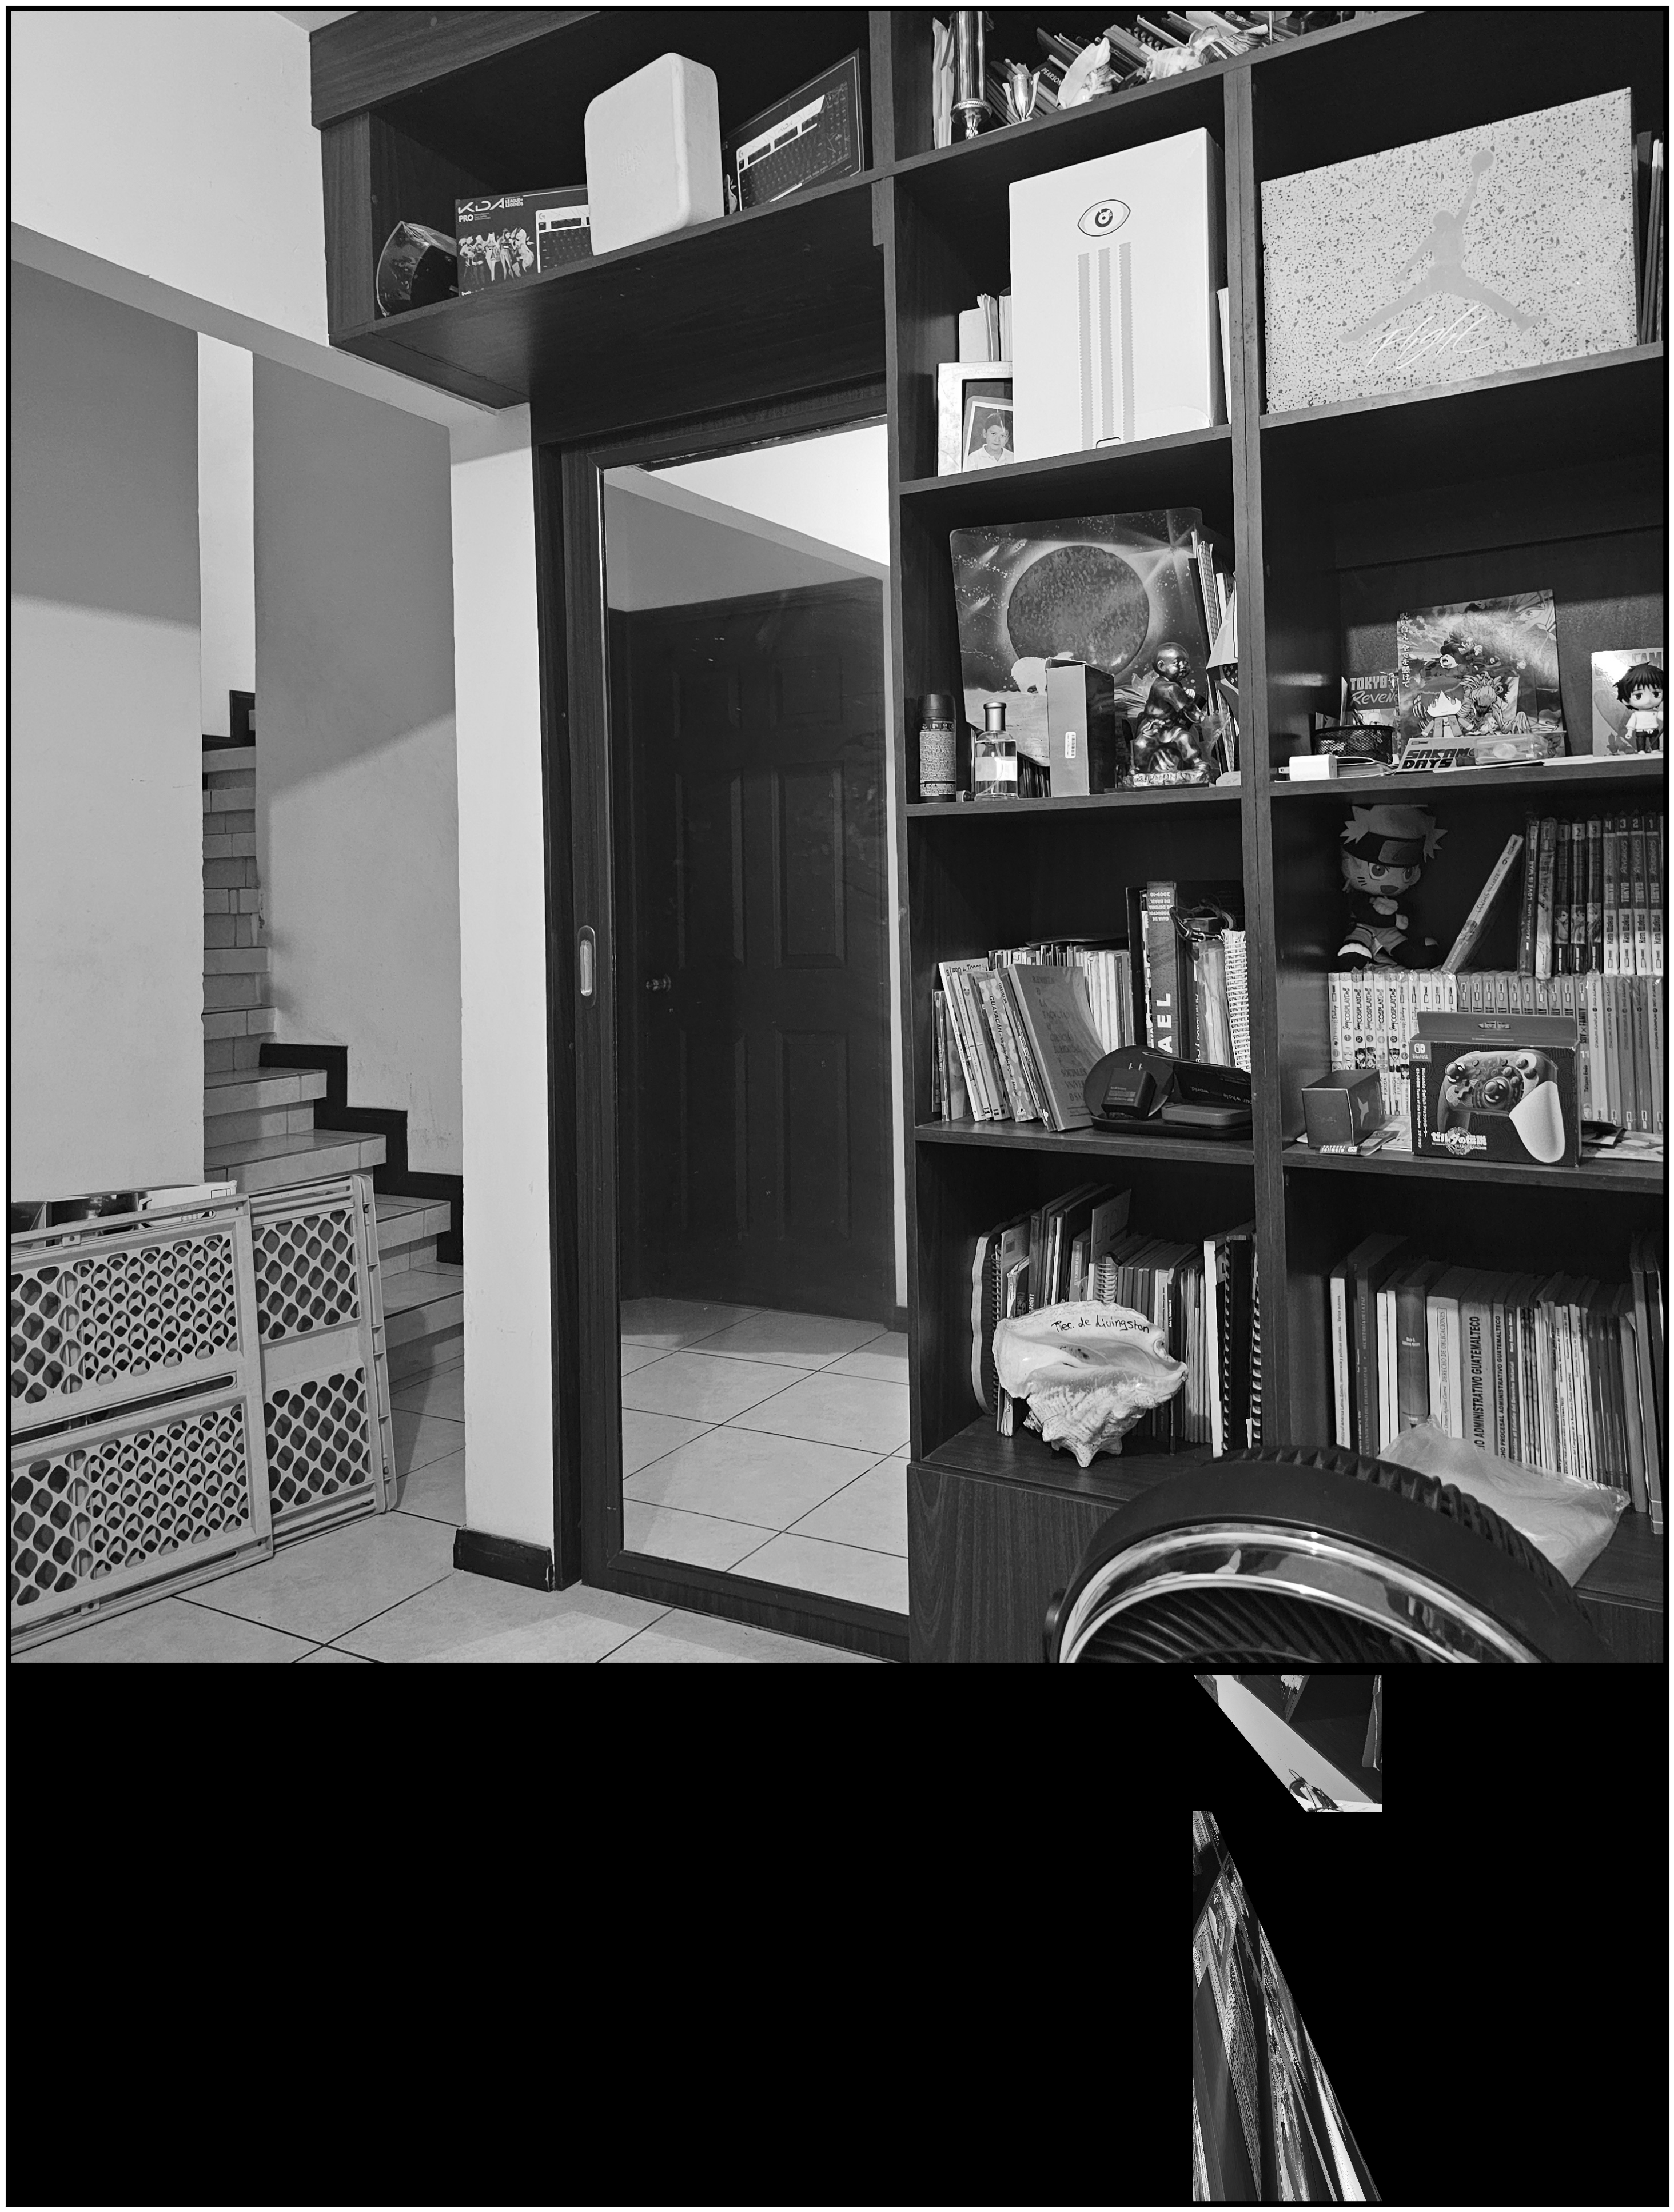

In [24]:
plt.figure(figsize=(50,50))
plt.imshow(panorama)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()